# Prediction Modeling Notebook

This notebook attempts to predict if a pollster will make the "right call" on a poll based on 538 poll data. Target was "rightcall" for all models. 

This notebook includes:

1. Baseline Analysis
2. Logistic Regression with Numeric Features (using StandardScaler and MinMaxScaler) 
3. Logistic Regression + Categorical Features (using StandardScaler) 
4. Simple Decision Tree (Cat + Num features)(using StandardScaler and MinMaxScaler)  - Best Model
5. Grid Search Decision Tree - (Numeric and Categorical) (StandardScaler)
6. Random Forrest Model - (Numeric and Categorical) (StandardScaler)
7. Decision Tree with Interaction Features using PolynomialFeatures

In [1]:
#imports
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  MinMaxScaler, StandardScaler, OneHotEncoder, PolynomialFeatures

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.model_selection import train_test_split, cross_val_score
from model_evaluator import evaluation

In [2]:
plt.style.use('ggplot')

In [3]:
polls = pd.read_csv('../data/raw-polls-updated.csv')
polls.head()

,poll_id,question_id,race_id,year,race,location,type_simple,type_detail,pollster,pollster_rating_id,...,averaged,state_agg,imputed_600,days_bt_polldate_election,Text,Live Phone,Mail,Face-to-Face,IVR,Online
0,26013,87909,1455,1998,1998_Gov-G_NY,NY,Gov-G,Gov-G,Blum & Weprin Associates,32,...,0,NY,0,21,0,1,0,0,0,0
1,26255,87926,1456,1998,1998_Gov-G_OH,OH,Gov-G,Gov-G,University of Cincinnati (Ohio Poll),346,...,0,OH,0,21,0,1,0,0,0,0
2,26026,31266,1736,1998,1998_Sen-G_NV,NV,Sen-G,Sen-G,FM3 Research,91,...,0,NV,0,21,0,1,0,0,0,0
3,26013,31253,1738,1998,1998_Sen-G_NY,NY,Sen-G,Sen-G,Blum & Weprin Associates,32,...,0,NY,0,21,0,1,0,0,0,0
4,63632,117103,1738,1998,1998_Sen-G_NY,NY,Sen-G,Sen-G,Garin-Hart-Yang Research Group,113,...,0,NY,0,21,0,1,0,0,0,0


### 1. Baseline

In [4]:
polls['rightcall'].value_counts(normalize=True)

rightcall
1.0    0.783593
0.0    0.179287
0.5    0.037120
Name: proportion, dtype: float64

In [5]:
#0.5 represents a dead heat so imputing to 0
right_call_baseline = polls['rightcall'].map({1:1, 0:0, 0.5:0})
right_call_baseline.value_counts(normalize=True)

rightcall
1    0.783593
0    0.216407
Name: proportion, dtype: float64

We are trying to predict if a pollster is going to make a right call based on the other features in the data set like error, year, methodology, and more. We know from our EDA research that these variables did not have very strong relationships with the "rightcall" target. 

For our purposes, we will use 0.783593 as our baseline for the models. As you can see we have imputed the 0.5 values to 0. A value of 0.5 means that the pollster had two or more candidates tied for the lead and one of the tied candidates won, according to the fivethirtyeight.

### 2. Logistic Regression - Numeric Features; Target - "rightcall", MinMaxScaler/StandardScaler 

In [6]:
#choosing numeric variables
X = polls[['year', 'days_bt_polldate_election', 'samplesize', 'cand1_pct', 'cand2_pct',  
             'calc_bias']]
y = polls['rightcall'].map({1:1, 0:0, 0.5:0})

In [7]:
#train, test, split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8, stratify=y)

In [8]:
#trying two different scaling methods 
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [9]:
#trying two different scaling methods 
mm = MinMaxScaler()
X_train_mm = sc.fit_transform(X_train)
X_test_mm = sc.transform(X_test)

In [10]:
#fitting the min max scaled data first
lg = LogisticRegression()
lg.fit(X_train_mm,y_train)

LogisticRegression()

In [11]:
print(f"Cross val R2: {cross_val_score(lg, X_train_mm, y_train).mean()}")
print(f"Testing R2: {lg.score(X_test_mm, y_test)}")

Cross val R2: 0.7842227378190255
Testing R2: 0.7838589981447124


In [12]:
#now fitting the with StandardScaler
lg = LogisticRegression()
lg.fit(X_train_sc,y_train)

LogisticRegression()

In [13]:
print(f"Cross val R2: {cross_val_score(lg, X_train_sc, y_train).mean()}")
print(f"Testing R2: {lg.score(X_test_sc, y_test)}")

Cross val R2: 0.7842227378190255
Testing R2: 0.7838589981447124


accuracy: 0.7838589981447124
recall: 0.9988158673771462
precision: 0.7842863784286378
f1 score: 0.8786458333333332


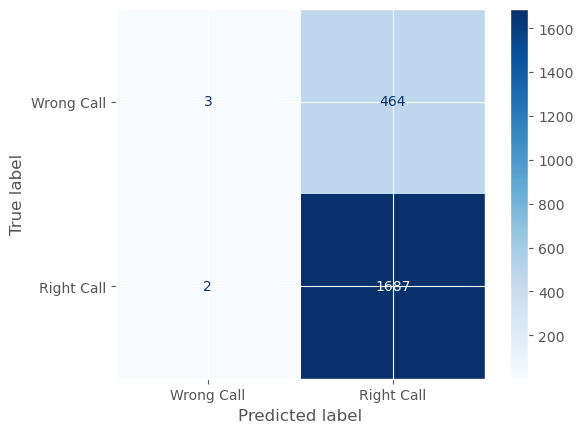

In [14]:
#making a confusion matrix
lg_org = evaluation(X_test_sc, y_test, lg);

With our baseline of .7836,  we can compare and see that both of these models (different scale methods) did not preform much better than the baseline, with a training score of around .7798 and a test score of .8000. Since our test score is higher than out training score, this is telling us that our model is underfit and we need to increase the complexity of our model. We now add in some categorical features to our model, including the features we created in our Cleaning process of this project (person,org,etc.)

We can see there was not a difference in using StandardScaler vs, MinMaxScaler for this Logistic Regression. 

### 3. Logistic Regression - Adding in Categorical Features; Target - "rightcall", StandardScaler 

In [15]:
#choosing the above variables plus categorical variables we can OHE
X = polls[['year', 'days_bt_polldate_election', 'samplesize', 'cand1_pct', 'cand2_pct',  
             'calc_bias', 'partisan', 'type_simple', 'org', 'person', 'anon',
          'registered_voters', 'averaged', 'imputed_600', 'Text', 'Live Phone', 'Mail',
          'Face-to-Face', 'IVR', 'Online']]
y = polls['rightcall'].map({1:1, 0:0, 0.5:0})

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8, stratify=y)

In [17]:
#Pipe to encode cat variables like partisan and type of race, scaling the data with SS
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

lg_pipe = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('ss', StandardScaler()),
        ('logr', LogisticRegression())
    ]
)

In [18]:
lg_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('patrisan_ct',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['partisan',
                                                   'type_simple'])])),
                ('ss', StandardScaler()), ('logr', LogisticRegression())])

In [19]:
#scores
print(f"Cross val R2: {cross_val_score(lg_pipe, X_train, y_train).mean()}")
print(f"Testing R2: {lg_pipe.score(X_test, y_test)}")

Cross val R2: 0.7832946635730857
Testing R2: 0.7829313543599258


accuracy: 0.7829313543599258
recall: 0.9952634695085849
precision: 0.7851471275105091
f1 score: 0.8778067885117492


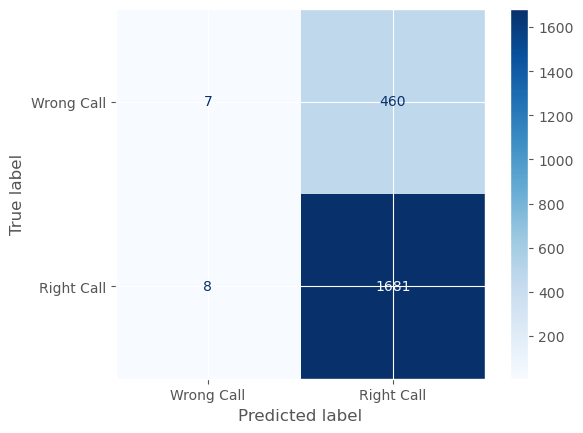

In [20]:
#making a confusion matrix
lg_cat = evaluation(X_test, y_test, lg_pipe);

With our baseline of .7836,  we can compare and see that adding in more categorical variables to make the model more complex did not help too much with a test score of 0.8014. Since our test score is higher than out training score, this is telling us that our model is still underfit and we need to increase the complexity of our model. We are now going to experiment with Decision Trees to see how this works as a model approach.

### 4. Simple Decision Tree - Same features as above (Numeric and Categorical) / StandardScaler v. MinMax

In [21]:
#choosing variables - same as above
X = polls[['year', 'days_bt_polldate_election', 'samplesize', 'cand1_pct', 'cand2_pct',  
             'calc_bias', 'partisan', 'type_simple', 'org', 'person', 'anon',
          'registered_voters', 'averaged', 'imputed_600', 'Text', 'Live Phone', 'Mail',
          'Face-to-Face', 'IVR', 'Online']]
y = polls['rightcall'].map({1:1, 0:0, 0.5:0})

In [22]:
#splitting data
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8, stratify=y)

In [23]:
#Pipe to encode cat variables like partisan and type of race, scaling the data with SS
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

dt_pl1 = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('ss', StandardScaler()),
        ('dt', DecisionTreeClassifier(random_state=42))
    ]
)

In [24]:
dt_pl1.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('patrisan_ct',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['partisan',
                                                   'type_simple'])])),
                ('ss', StandardScaler()),
                ('dt', DecisionTreeClassifier(random_state=42))])

In [25]:
print(f"Cross val R2: {cross_val_score(dt_pl1, X_train, y_train).mean()}")
print(f"Testing R2: {dt_pl1.score(X_test, y_test)}")

Cross val R2: 0.9201856148491878
Testing R2: 0.9216141001855288


accuracy: 0.9216141001855288
recall: 0.9455298993487271
precision: 0.9540023894862605
f1 score: 0.9497472494796312


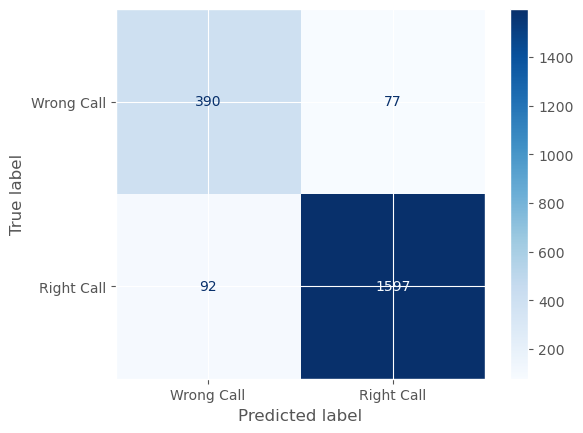

In [26]:
#making a confusion matrix
dt_1 = evaluation(X_test, y_test, dt_pl1);

Trying Single Dec. Tree MinMaxScaler to see if it helps the model before analyzing...

In [27]:
X = polls[['year', 'days_bt_polldate_election', 'samplesize', 'cand1_pct', 'cand2_pct',  
             'calc_bias', 'partisan', 'type_simple', 'org', 'person', 'anon',
          'registered_voters', 'averaged', 'imputed_600', 'Text', 'Live Phone', 'Mail',
          'Face-to-Face', 'IVR', 'Online']]
y = polls['rightcall'].map({1:1, 0:0, 0.5:0})

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8)

In [29]:
#Pipe to encode cat variables like partisan and type of race, scaling the data with MinMaxScaler
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

dt_pl2 = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('mm', MinMaxScaler()),
        ('dt', DecisionTreeClassifier(random_state=42))
    ]
)

In [30]:
dt_pl2.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('patrisan_ct',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['partisan',
                                                   'type_simple'])])),
                ('mm', MinMaxScaler()),
                ('dt', DecisionTreeClassifier(random_state=42))])

In [31]:
print(f"Cross val R2: {cross_val_score(dt_pl2, X_train, y_train).mean()}")
print(f"Testing R2: {dt_pl2.score(X_test, y_test)}")

Cross val R2: 0.9194895591647331
Testing R2: 0.9313543599257885


accuracy: 0.9313543599257885
recall: 0.9495066744051074
precision: 0.9640542133176193
f1 score: 0.9567251461988303


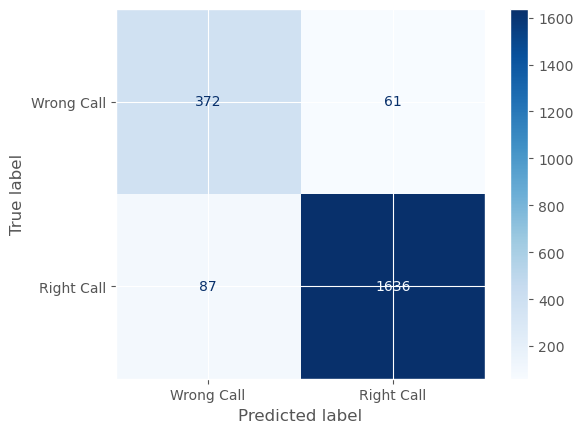

In [32]:
#making a confusion matrix
dt_2 = evaluation(X_test, y_test, dt_pl2);

We can see that Decision Tree modeling is working really well with this data with around a 0.93 accuracy score on the testing data and 0.92 on the training data. Using StandardScaler v. MinMaxScaler made a very small improvement when using MinMaxScaler in the modeling. We can see the modeling, compared to logistic regression, is now guessing more "wrong calls" (instances when the polls were wrong), increasing the precision score and decreasing the recall score. It seems in earlier modeling attempts, the models were mostly guessing "right call" around 99 percent of the time, resulting in an accuracy score around 78 that was close to our baseline. Now we can see this model is working better to detect "wrong calls" using decision trees.

### 5. Grid Search Decision Tree - Same features as above (Numeric and Categorical) / StandardScaler

In [33]:
X = polls[['year', 'days_bt_polldate_election', 'samplesize', 'cand1_pct', 'cand2_pct',  
             'calc_bias', 'partisan', 'type_simple', 'org', 'person', 'anon',
          'registered_voters', 'averaged', 'imputed_600', 'Text', 'Live Phone', 'Mail',
          'Face-to-Face', 'IVR', 'Online']]
y = polls['rightcall'].map({1:1, 0:0, 0.5:0})

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8, stratify=y)

In [35]:
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

dt_pl3 = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('mm', MinMaxScaler()),
        ('dt', DecisionTreeClassifier(random_state=42))
    ]
)

In [36]:
                               
dt_grid = GridSearchCV(estimator=dt_pl3,
                   param_grid={'dt__max_depth' : [3, 5, 7, 10, None],
                              'dt__min_samples_split' : [2, 5, 10, 15, 20],
                               'dt__class_weight' : ["balanced", None],
                              'dt__min_samples_leaf' : [1, 2, 3, 4, 5, 6, 7]},
                   cv = 5,
                   verbose=1)

In [37]:
dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 350 candidates, totalling 1750 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('patrisan_ct',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['partisan',
                                                                          'type_simple'])])),
                                       ('mm', MinMaxScaler()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dt__class_weight': ['balanced', None],
                         'dt__max_depth': [3, 5, 7, 10, None],
                         'dt__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
                         'dt__min_samples_split': [2, 5, 10, 15, 20]},
             verbose=1)

In [38]:
dt_grid.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('patrisan_ct',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['partisan',
                                                   'type_simple'])])),
                ('mm', MinMaxScaler()),
                ('dt',
                 DecisionTreeClassifier(min_samples_leaf=3, random_state=42))])

In [39]:
dt_grid.best_score_

0.9235498839907192

We can see that Decision Tree modeling is still working really well with this data. However, hypertuning our parameters did not improve our accuracy score and the un-hypertuned decision tree preformed the best with an accuracy score of 0.93 which is a little higher than the best preforming model in our grid search of 0.92. This should be because the model chosen by the grid search did better in the cv, but happened to perform slightly worse on the test set.

### 6. Random Forrest Model

In [40]:
X = polls[['year', 'days_bt_polldate_election', 'samplesize', 'cand1_pct', 'cand2_pct',  
             'calc_bias', 'partisan', 'type_simple', 'org', 'person', 'anon',
          'registered_voters', 'averaged', 'imputed_600', 'Text', 'Live Phone', 'Mail',
          'Face-to-Face', 'IVR', 'Online']]
y = polls['rightcall'].map({1:1, 0:0, 0.5:0})

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8, stratify=y)

In [42]:
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

rf_pipe = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('mm', MinMaxScaler()),
        ('rf', RandomForestClassifier(random_state=42))
    ]
)

In [43]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('patrisan_ct',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['partisan',
                                                   'type_simple'])])),
                ('mm', MinMaxScaler()),
                ('rf', RandomForestClassifier(random_state=42))])

In [44]:
rf_cv_scores = cross_val_score(rf_pipe, X_train, y_train)
print(rf_cv_scores)
print(rf_cv_scores.mean())
print(rf_cv_scores.std())

[0.90719258 0.91183295 0.90023202 0.90023202 0.89675174]
0.9032482598607888
0.005470916994223493


In [45]:
print(rf_pipe.score(X_test,y_test))

0.9016697588126159


We can see that random forest modeling is still working really well with this data. However, the un-hypertuned decision tree preformed the best with an accuracy score of 0.93 which is a higher than the the base random forrest model at 0.90. 

### 7. Model with Interaction Features using PolynomialFeatures

In [46]:
X = polls[['year', 'days_bt_polldate_election', 'samplesize', 'cand1_pct', 'cand2_pct',  
             'calc_bias', 'partisan', 'type_simple', 'org', 'person', 'anon',
          'registered_voters', 'averaged', 'imputed_600', 'Text', 'Live Phone', 'Mail',
          'Face-to-Face', 'IVR', 'Online']]
y = polls['rightcall'].map({1:1, 0:0, 0.5:0})

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8, stratify=y)

In [48]:
partisaner = Pipeline( # OneHotEncodes race type and partisan
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

interaction_pipe = Pipeline(
    [
        ('poly', PolynomialFeatures(include_bias = False, interaction_only = True))
    ]
)

preprocessing_pipe = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple']),
                ('features', interaction_pipe, ['Live Phone', 'IVR', 'Online', 'imputed_600', 'samplesize'])
            ],
            remainder = 'passthrough'
            )
        )
    ]
)

dt_polypipe = Pipeline(
    [
        ('pre', preprocessing_pipe),
        ('mm', MinMaxScaler()),
        ('dt', DecisionTreeClassifier(random_state=42))
    ]
)

In [49]:
dt_polypipe.fit(X_train,y_train)

Pipeline(steps=[('pre',
                 Pipeline(steps=[('ct',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('patrisan_ct',
                                                                   Pipeline(steps=[('ohe',
                                                                                    OneHotEncoder(drop='first'))]),
                                                                   ['partisan',
                                                                    'type_simple']),
                                                                  ('features',
                                                                   Pipeline(steps=[('poly',
                                                                                    PolynomialFeatures(include_bias=False,
                                                                                                       interaction_only=True))]),
                                                                   ['Live '
                                                                    'Phone',
                                                                    'IVR',
                                                                    'Online',
                                                                    'imputed_600',
                                                                    'samplesize'])]))])),
                ('mm', MinMaxScaler()),
                ('dt', DecisionTreeClassifier(random_state=42))])

accuracy: 0.9257884972170687
recall: 0.9538188277087034
precision: 0.9515652687536916
f1 score: 0.9526907155529272


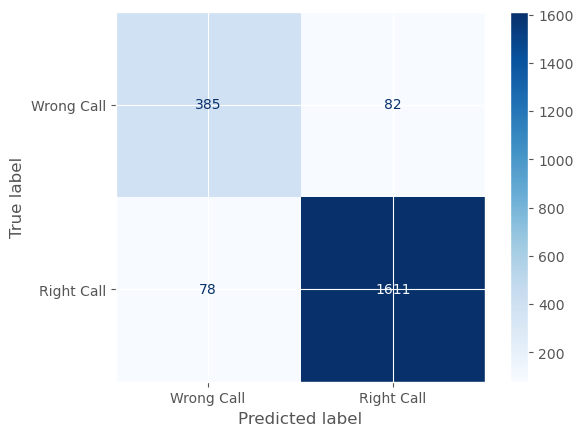

In [50]:
#making a confusion matrix
dt_poly = evaluation(X_test, y_test, dt_polypipe);

In [51]:
print(f"Cross val R2: {cross_val_score(dt_polypipe, X_train, y_train).mean()}")
print(f"Testing R2: {dt_polypipe.score(X_test, y_test)}")

Cross val R2: 0.9189095127610208
Testing R2: 0.9257884972170687


We attempted to use PolynominalFeatures to create Interaction features to make our model more complex. We decided to use the three most popular polling methodologies (Live Phone, IVR, and Online), as well as both imputed600 and sample size because they're directly related. The methodologies were originally paired together on each row of data, ex. (Live Phone/Online) so we split up and mapped out that data, and now created interaction features. The "imputed_600" variable was extracted from the comment section of the polling data set in cases where the polling  sample size was imputed to 600. The feature interaction step did not increase our accuracy score from the un-tuned decision tree that acheived a .93 score.